In [1]:
li_no_w=[]
li_w=[]

In [2]:
import cv2

# 打开第一个视频文件
no = cv2.VideoCapture('no.mp4')

# 获取第一个视频的帧数
total_frames1 = int(no.get(cv2.CAP_PROP_FRAME_COUNT))

# 循环读取每一帧并保存
for i in range(total_frames1):
    ret, frame = no.read()
    if ret:
        li_no_w.append(frame)
    else:
        break

# 释放第一个视频
no.release()

# 打开第二个视频文件
w = cv2.VideoCapture('w.mp4')

# 获取第二个视频的帧数
total_frames2 = int(w.get(cv2.CAP_PROP_FRAME_COUNT))

# 循环读取每一帧并保存
for i in range(total_frames2):
    ret, frame = w.read()
    if ret:
        li_w.append(frame)
    else:
        break

# 释放第二个视频
w.release()

In [3]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value
import argparse
import copy
from tqdm import tqdm
from statistics import mean, stdev
from sklearn import metrics

import torch
from diffusers import DPMSolverMultistepScheduler
from tree_ring.inverse_stable_diffusion import InversableStableDiffusionPipeline
import open_clip
from tree_ring.optim_utils import *
from tree_ring.io_utils import *
import re
device = 'cuda' if torch.cuda.is_available() else 'cpu'

/root/miniconda3/envs/integrate/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
parser = argparse.ArgumentParser(description='diffusion watermark')
parser.add_argument('--model_id', default='/root/.cache/huggingface/diffusers/models--stabilityai--stable-diffusion-2-1-base/snapshots/5ede9e4bf3e3fd1cb0ef2f7a3fff13ee514fdf06/')
parser.add_argument('--test_num_inference_steps', default=None, type=int)
parser.add_argument('--num_inference_steps', default=50, type=int)

# watermark
parser.add_argument('--w_mask_shape', default='circle')

parser.add_argument('--w_measurement', default='l1_complex')
parser.add_argument('--w_radius', default=10)
parser.add_argument('--w_channel', default=0, type=int)


# for image distortion
args = parser.parse_args([])

if args.test_num_inference_steps is None:
    args.test_num_inference_steps = args.num_inference_steps

In [5]:
scheduler = DPMSolverMultistepScheduler.from_pretrained(args.model_id, subfolder='scheduler')
pipe = InversableStableDiffusionPipeline.from_pretrained(
    args.model_id,
    scheduler=scheduler,
    torch_dtype=torch.float16,
    revision='fp16',
    )
pipe = pipe.to(device)

/root/miniconda3/envs/integrate/lib/python3.9/site-packages/transformers/modeling_utils.py:402: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(checkpoint_file, framework="pt") as f:


In [6]:
tester_prompt = '' # assume at the detection time, the original prompt is unknown
text_embeddings = pipe.get_text_embedding(tester_prompt)

# ground-truth patch
gt_patch = torch.load('./tree_ring/key.pt').to(dtype=torch.complex32)
init_latents_w = pipe.get_random_latents()
watermarking_mask = get_watermarking_mask(init_latents_w, args, device)
no_w_metrics=[]
w_metrics=[]

/tmp/ipykernel_1481505/301511426.py:5: UserWarning: ComplexHalf support is experimental and many operators don't support it yet. (Triggered internally at ../aten/src/ATen/EmptyTensor.cpp:31.)
  gt_patch = torch.load('./tree_ring/key.pt').to(dtype=torch.complex32)


In [7]:
from PIL import Image
for idx in range(16):
    img_no_w = Image.fromarray(li_no_w[idx])
    img_w = Image.fromarray(li_w[idx])
    
    img_no_w = transform_img(img_no_w).unsqueeze(0).to(text_embeddings.dtype).to(device)
    img_w = transform_img(img_w).unsqueeze(0).to(text_embeddings.dtype).to(device)
    
    image_latents_no_w = pipe.get_image_latents(img_no_w, sample=False)
    image_latents_w = pipe.get_image_latents(img_w, sample=False)
    
    reversed_latents_no_w = pipe.forward_diffusion(
    latents=image_latents_no_w,
    text_embeddings=text_embeddings,
    guidance_scale=1,
    num_inference_steps=10,
    )

    reversed_latents_w = pipe.forward_diffusion(
    latents=image_latents_w,
    text_embeddings=text_embeddings,
    guidance_scale=1,
    num_inference_steps=10,
    )
    no_w_metric, w_metric = eval_watermark(reversed_latents_no_w, reversed_latents_w, watermarking_mask, gt_patch, args)
    no_w_metrics.append(-no_w_metric)
    w_metrics.append(-w_metric)


100%|██████████| 10/10 [00:00<00:00, 54.58it/s]


In [8]:
for idx in range(len(no_w_metrics)):
    print(no_w_metrics[idx],w_metrics[idx])

-68.75 -70.75
-75.125 -69.625
-67.875 -70.6875
-70.0625 -70.125
-70.375 -72.1875
-68.25 -73.0
-72.25 -72.1875
-76.875 -71.375
-71.75 -71.0625
-76.1875 -70.875
-72.75 -72.875
-72.6875 -72.0
-73.625 -71.625
-73.0 -72.0625
-73.25 -73.0625
-75.0 -70.3125


In [9]:
preds = no_w_metrics +  w_metrics
t_labels = [0] * len(no_w_metrics) + [1] * len(w_metrics)
fpr, tpr, thresholds = metrics.roc_curve(t_labels, preds, pos_label=1)
auc = metrics.auc(fpr, tpr)
acc = np.max(1 - (fpr + (1 - tpr))/2)
low = tpr[np.where(fpr<.01)[0][-1]]
print(acc)

0.71875


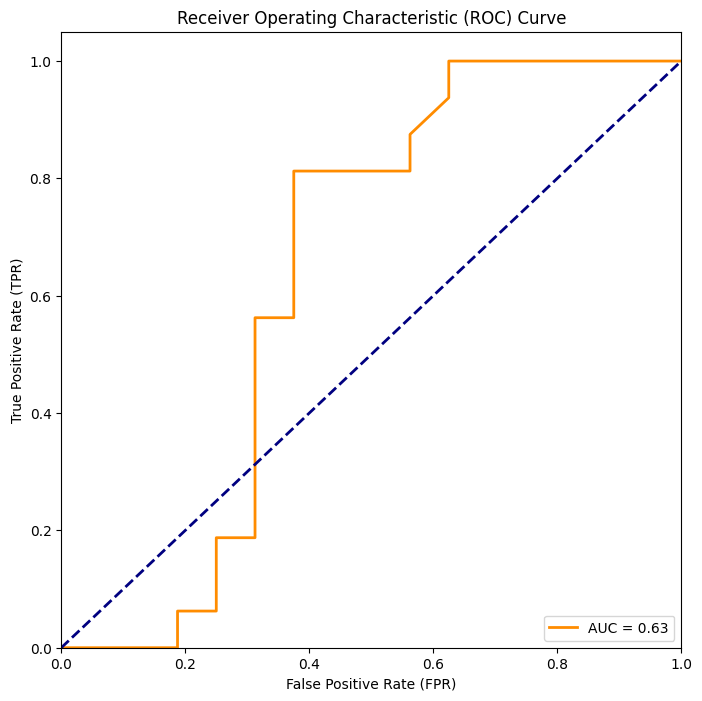

In [10]:
import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()